<a href="https://colab.research.google.com/github/Lucs1590/vgg_bpca/blob/master/vgg_net.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# VGG NET
Here we are using a VGG net with 19 layers with the dataset cifar 100.

We are trying to reproduce the results of the paper [1] and after we will try to change some layers and see how it affects the results.

[1] https://arxiv.org/pdf/1409.1556.pdf


## Imports

In [21]:
import os
import itertools
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import numpy as np
import random
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.datasets import cifar100
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications import efficientnet
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import Activation, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, GlobalAveragePooling2D 
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard

from keras import backend
from keras.layers import VersionAwareLayers
from keras.engine import training
from keras.utils import layer_utils
from keras.applications import imagenet_utils

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

## Load the dataset

In [3]:
np.random.seed(77)
tf.random.set_seed(77)

In [4]:
(X_train, y_train), (X_test, y_test) = cifar100.load_data()
X_train = X_train / 255.0
X_test = X_test / 255.0

169001437/169001437 [==============================] - 2s 0us/step


We will split the test set in two parts, where one of this will be used to validation. After that we will declare the classes and plot some random images.

In [5]:
X_test, X_valid, y_test, y_valid = train_test_split(X_test, y_test, test_size=0.7)

In [6]:
labels =  ['apple', 'aquarium_fish', 'baby', 'bear', 'beaver', 'bed', 'bee', 'beetle', 'bicycle', 'bottle', 'bowl', 'boy', 'bridge', 'bus', 'butterfly', 
           'camel', 'can', 'castle', 'caterpillar', 'cattle', 'chair', 'chimpanzee', 'clock', 'cloud', 'cockroach', 'couch', 'crab', 'crocodile', 'cup', 
           'dinosaur', 'dolphin', 'elephant', 'flatfish', 'forest', 'fox', 'girl', 'hamster', 'house', 'kangaroo', 'computer_keyboard', 
           'lamp', 'lawn_mower', 'leopard', 'lion', 'lizard', 'lobster', 'man', 'maple_tree', 'motorcycle', 'mountain', 'mouse', 'mushroom', 
           'oak_tree', 'orange', 'orchid', 'otter', 'palm_tree', 'pear', 'pickup_truck', 'pine_tree', 'plain', 'plate', 'poppy', 'porcupine', 'possum', 
           'rabbit', 'raccoon', 'ray', 'road', 'rocket', 'rose', 'sea', 'seal', 'shark', 'shrew', 'skunk', 'skyscraper', 'snail', 'snake', 'spider',
           'squirrel', 'streetcar', 'sunflower', 'sweet_pepper', 'table', 'tank', 'telephone', 'television', 'tiger', 'tractor', 'train', 'trout',
           'tulip', 'turtle', 'wardrobe', 'whale', 'willow_tree', 'wolf', 'woman', 'worm']

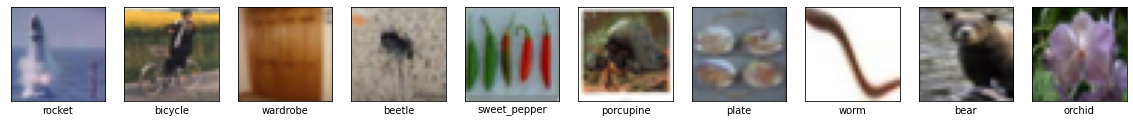

In [7]:
plt.figure(figsize=(20, 3))

for i in range(10):
    plt.subplot(1, 10, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)

    numb = random.randint(0,len(X_train))

    plt.imshow(X_train[numb], cmap="gray")
    plt.xlabel(labels[y_train[numb].astype(int)[0]])
    
plt.show()

Here the data will be converted to a scale between 0 and 1.

In [8]:
print(f'Train: {len(X_train)}')
print(f'Test: {len(X_test)}')
y_train = to_categorical(y_train, 100)
y_test = to_categorical(y_test, 100)
y_valid = to_categorical(y_valid, 100)

Train: 50000
Test: 3000


The last thing in this step is apply a lot of filters to the train dataset.

In [12]:
datagen = ImageDataGenerator(
    height_shift_range=0.2,
    width_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    rotation_range=40,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest',
)

datagen.fit(X_train)

## VGG 19 Architecture

In [22]:
layers = VersionAwareLayers()

def VGG19(
    include_top=True,
    weights="imagenet",
    input_tensor=None,
    input_shape=None,
    pooling=None,
    classes=1000,
    classifier_activation="softmax",
):
    # Determine proper input shape
    input_shape = imagenet_utils.obtain_input_shape(
        input_shape,
        default_size=224,
        min_size=32,
        data_format=backend.image_data_format(),
        require_flatten=include_top,
        weights=weights,
    )

    if input_tensor is None:
        img_input = layers.Input(shape=input_shape)
    else:
        if not backend.is_keras_tensor(input_tensor):
            img_input = layers.Input(tensor=input_tensor, shape=input_shape)
        else:
            img_input = input_tensor
    # Block 1
    x = layers.Conv2D(64, (3, 3), activation="relu", padding="same", name="block1_conv1")(img_input)
    x = layers.Conv2D(64, (3, 3), activation="relu", padding="same", name="block1_conv2")(x)
    x = layers.MaxPooling2D((2, 2), strides=(2, 2), name="block1_pool")(x)

    # Block 2
    x = layers.Conv2D(128, (3, 3), activation="relu", padding="same", name="block2_conv1")(x)
    x = layers.Conv2D(128, (3, 3), activation="relu", padding="same", name="block2_conv2")(x)
    x = layers.MaxPooling2D((2, 2), strides=(2, 2), name="block2_pool")(x)

    # Block 3
    x = layers.Conv2D(256, (3, 3), activation="relu", padding="same", name="block3_conv1")(x)
    x = layers.Conv2D(256, (3, 3), activation="relu", padding="same", name="block3_conv2")(x)
    x = layers.Conv2D(256, (3, 3), activation="relu", padding="same", name="block3_conv3")(x)
    x = layers.Conv2D(256, (3, 3), activation="relu", padding="same", name="block3_conv4")(x)
    x = layers.MaxPooling2D((2, 2), strides=(2, 2), name="block3_pool")(x)

    # Block 4
    x = layers.Conv2D(512, (3, 3), activation="relu", padding="same", name="block4_conv1")(x)
    x = layers.Conv2D(512, (3, 3), activation="relu", padding="same", name="block4_conv2")(x)
    x = layers.Conv2D(512, (3, 3), activation="relu", padding="same", name="block4_conv3")(x)
    x = layers.Conv2D(512, (3, 3), activation="relu", padding="same", name="block4_conv4")(x)
    x = layers.MaxPooling2D((2, 2), strides=(2, 2), name="block4_pool")(x)

    # Block 5
    x = layers.Conv2D(512, (3, 3), activation="relu", padding="same", name="block5_conv1")(x)
    x = layers.Conv2D(512, (3, 3), activation="relu", padding="same", name="block5_conv2")(x)
    x = layers.Conv2D(512, (3, 3), activation="relu", padding="same", name="block5_conv3")(x)
    x = layers.Conv2D(512, (3, 3), activation="relu", padding="same", name="block5_conv4")(x)
    x = layers.MaxPooling2D((2, 2), strides=(2, 2), name="block5_pool")(x)

    if pooling == "avg":
        x = layers.GlobalAveragePooling2D()(x)
    elif pooling == "max":
        x = layers.GlobalMaxPooling2D()(x)

    if input_tensor is not None:
        inputs = layer_utils.get_source_inputs(input_tensor)
    else:
        inputs = img_input

    model = training.Model(inputs, x, name="vgg19")

    if weights is not None:
        model.load_weights(weights)

    return model

In [25]:
def densenet(input_shape, n_classes):
    """
    Build model from DenseNet. Retrain last 5 layers and adds 2 Dense layers.
    :param input_shape: shape of single image
    :param n_classes: number of classes for prediction
    :return model: compiled model
    """
    base_model = efficientnet.EfficientNetB0(input_shape=input_shape,
                                      weights="imagenet",
                                      include_top=False,
                                      classes=len(labels))

    model = Sequential()
    model.add(base_model)
    model.add(GlobalAveragePooling2D())
    model.add(Dropout(0.5))
    model.add(Dense(n_classes, activation='softmax'))
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    return model

In [26]:
vgg_model = VGG19(weights=None, input_shape=(32, 32, 3), classes=100)
vgg_model.summary()

Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 34, 34, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 34, 34, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 34, 34, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 17, 17, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 17, 17, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 17, 17, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 8, 8, 128)         0     

In [27]:
dense_model = densenet(input_shape=(32, 32, 3), n_classes=len(labels))
dense_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb0 (Functional)  (None, 1, 1, 1280)       4049571   
                                                                 
 global_average_pooling2d_2   (None, 1280)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dropout_2 (Dropout)         (None, 1280)              0         
                                                                 
 dense_2 (Dense)             (None, 100)               128100    
                                                                 
Total params: 4,177,671
Trainable params: 4,135,648
Non-trainable params: 42,023
_________________________________________________________________


## Training

In [28]:
model_checkpointer = ModelCheckpoint('cifar100_densemodel_bm.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)
history = dense_model.fit(
    datagen.flow(X_train, y_train, batch_size=128, shuffle=True),
    validation_data=(X_valid, y_valid), epochs=150, verbose=1,
    callbacks=[
        EarlyStopping(monitor='val_accuracy', mode='max', verbose=1, patience=15),
        model_checkpointer
    ]
)

Epoch 1/150
391/391 [==============================] - ETA: 0s - loss: 4.1786 - accuracy: 0.0793
Epoch 1: val_accuracy improved from -inf to 0.01086, saving model to cifar100_densemodel_bm.h5
391/391 [==============================] - 49s 81ms/step - loss: 4.1786 - accuracy: 0.0793 - val_loss: 6.1032 - val_accuracy: 0.0109
Epoch 2/150
391/391 [==============================] - ETA: 0s - loss: 3.3191 - accuracy: 0.1959
Epoch 2: val_accuracy did not improve from 0.01086
391/391 [==============================] - 29s 73ms/step - loss: 3.3191 - accuracy: 0.1959 - val_loss: 10.2322 - val_accuracy: 0.0100
Epoch 3/150
391/391 [==============================] - ETA: 0s - loss: 2.9469 - accuracy: 0.2627
Epoch 3: val_accuracy did not improve from 0.01086
391/391 [==============================] - 29s 74ms/step - loss: 2.9469 - accuracy: 0.2627 - val_loss: 6.3904 - val_accuracy: 0.0071
Epoch 4/150
263/391 [===================>..........] - ETA: 8s - loss: 2.7515 - accuracy: 0.2968

KeyboardInterrupt: ignored

## Test

## Results